In [18]:
import json
import numpy
import random

from sklearn.svm import SVC

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [19]:
def was_blocked(shot):
    if 'info' in shot['extracts']:
        return 'BLOCK' in shot['extracts']['info']
    
    return False

def was_missed(shot):
    if 'info' in shot['extracts']:
        return 'MISS' in shot['extracts']['info']
    
    return False

def get_location(shot):
    return shot['location']['x'], shot['location']['y']

def get_points(shots):
    X = []
    y = []

    for shot in shots:
        x1, y1 = get_location(shot)
        
        X.append(x1)
        y.append(y1)

    return X, y

In [20]:
shots = []
with open('./data/shots.json', 'r') as shots_input_file:
    shots = json.loads(shots_input_file.read(),)

print(len(shots))

42863


In [21]:
plum = list(filter(lambda a: a['player']['id'] == '3065570', shots))

locs_made = []
locs_missing = []

for shot in plum:
    if shot['extracts']['text'] == 'free throw':
        continue
    
    if shot['made']:
        locs_made.append(shot)
    else:
        locs_missing.append(shot)

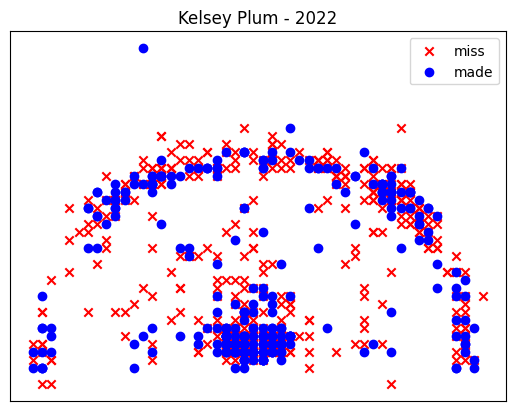

In [22]:
import matplotlib.pyplot as plt

plt.title('Kelsey Plum - 2022')

plt.scatter(*get_points(locs_missing), marker='x', c='r', label='miss')
plt.scatter(*get_points(locs_made), c='b', label='made')

plt.yticks([])
plt.xticks([])

plt.legend()

In [23]:
shot_groups = {
    '1PT': [],
    '2PT': [],
    '3PT': [],
    'N/A': [],
}

for shot in shots:
    shot_groups[shot['type']['label']].append(shot)

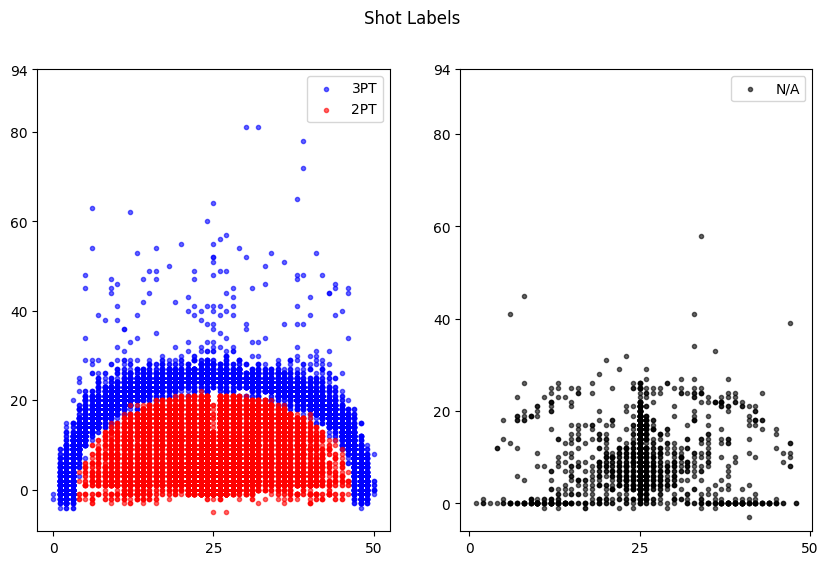

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

fig.suptitle('Shot Labels')

axs[0].scatter(*get_points(shot_groups['3PT']), marker='.', c='b', label='3PT', alpha=.6)
axs[0].scatter(*get_points(shot_groups['2PT']), marker='.', c='r', label='2PT', alpha=.6)

axs[0].legend()
axs[0].set_xticks([0, 25, 50])
axs[0].set_yticks([0, 20, 40, 60, 80, 94])


axs[1].scatter(*get_points(shot_groups['N/A']), marker='.', c='k', label='N/A', alpha=.6)
axs[1].legend()
axs[1].set_xticks([0, 25, 50])
axs[1].set_yticks([0, 20, 40, 60, 80, 94])



In [25]:
data = []

for shot in shot_groups['3PT']:
    location = shot['location']

    x = location['x']
    y = location['y']

    data.append([x, y, 1])

for shot in shot_groups['2PT']:
    location = shot['location']

    x = location['x']
    y = location['y']

    data.append([x, y, 0])
    
random.shuffle(data)

X = []
target = []

for x, y, t in data:
    X.append([x, y])
    target.append(t)

model = SVC()
model.fit(X, target)

model.score(X, target)

0.9975606743654666

In [26]:
for shot in shot_groups['2PT']:
    
    location = shot['location']

    x = location['x']
    y = location['y']

    ans = model.predict([[x, y]])
    
    if ans[0] != 0:
        print(shot)
    

{'team': {'id': '16', 'abbr': 'WSH'}, 'player': {'id': '3058893', 'name': 'Shatori Walker-Kimbrough'}, 'homeAway': 'home', 'is_neutral_site': False, 'quarter': 4, 'location': {'x': 46, 'y': 1}, 'text': 'Shatori Walker-Kimbrough misses 21-foot jumper', 'made': False, 'order': 0, 'type': {'id': '92', 'text': 'Jump Shot', 'label': '2PT'}, 'extracts': {'info': ['MISS'], 'distance': {'value': 21, 'unit': 'foot'}, 'text': 'jumper'}}
{'team': {'id': '3', 'abbr': 'DAL'}, 'player': {'id': '2566453', 'name': 'Isabelle Harrison'}, 'homeAway': 'home', 'is_neutral_site': False, 'quarter': 3, 'location': {'x': 14, 'y': 19}, 'text': 'Isabelle Harrison misses 21-foot jumper', 'made': False, 'order': 0, 'type': {'id': '92', 'text': 'Jump Shot', 'label': '2PT'}, 'extracts': {'info': ['MISS'], 'distance': {'value': 21, 'unit': 'foot'}, 'text': 'jumper'}}
{'team': {'id': '3', 'abbr': 'DAL'}, 'player': {'id': '3904576', 'name': 'Marina Mabrey'}, 'homeAway': 'away', 'is_neutral_site': False, 'quarter': 2, '

In [27]:
def plot(X, y):
    plot_decision_regions(
        numpy.array(X), 
        numpy.array(y), 
        clf=model,
        legend=2
    )

    plt.show()

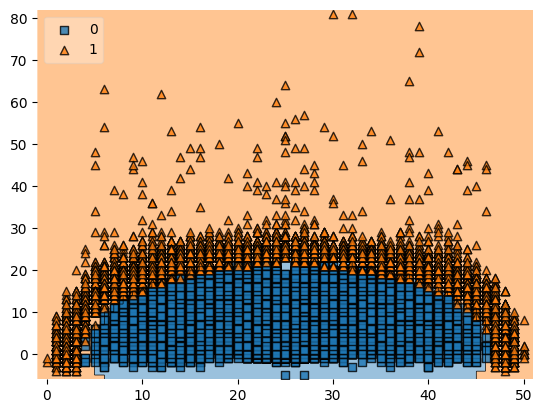

In [28]:
plot(X, target)

In [29]:
X_unknown = []
target_unknown = []

for shot in shot_groups['N/A']:
    location = list(get_location(shot))
    observation = model.predict([location])[0]

    shot['label'] = '3PT' if observation == 1 else '2PT'

    X_unknown.append(location)
    target_unknown.append(observation)

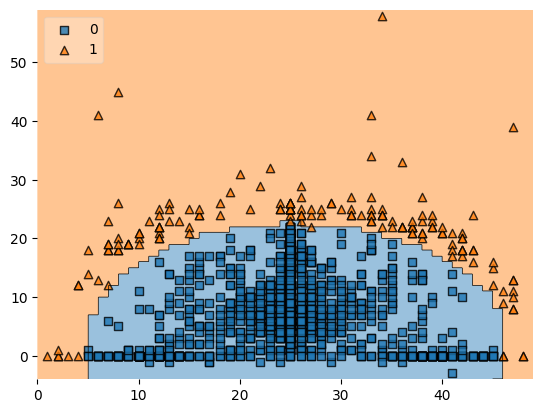

In [30]:
plot(X_unknown, target_unknown)